# Word Segmentation and Character Classification

## Imports

In [35]:
import io
import glob
import cv2
import PIL.Image
import math
import tensorflow as tf
import numpy as np
np.set_printoptions(suppress=True)

from natsort import natsorted
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from IPython.display import clear_output, Image, display
from keras.models import load_model
from util.WordSegmentation import wordSegmentation, prepareImg

In [41]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
)
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)

input_files = 'output_files/image-data/image-data/'

In [3]:
class_names = [
    "Alef",
    "Ayin",
    "Bet",
    "Dalet",
    "Gimel",
    "He",
    "Het",
    "Kaf",
    "Kaf-final",
    "Lamed",
    "Mem",
    "Mem-medial",
    "Nun-final",
    "Nun-medial",
    "Pe",
    "Pe-final",
    "Qof",
    "Resh",
    "Samekh",
    "Shin",
    "Taw",
    "Tet",
    "Tsadi-final",
    "Tsadi-medial",
    "Waw",
    "Yod",
    "Zayin"
]

In [4]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [5]:
model = load_model('neural_net_models/lenet5.best.hdf5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 44, 28, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 10, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 720)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               86520     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                10164     
__________

## Load in slices and apply word segmentation

In [146]:
def load_slices(filepath):
    slices = []
    slices_filepath = filepath + '/'
    slices_path = natsorted(glob.glob(slices_filepath + 'slice*_binarize.png'))
    for slice_path in slices_path:
        slices.append(prepareImg(cv2.imread(slice_path), 50))  
    print(len(slices))
    return slices

output_files/image-data/image-data\P583-Fg002-R-C01-R01-fused
12
14
11
8
13
8
10
11
8
12
14
11
11
9
10
7
7
9
8
7


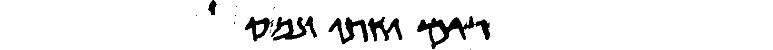

In [150]:
image_filepaths = glob.glob(input_files + '*')
print(image_filepaths[len(image_filepaths) - 5])
images = []
for image_filepath in image_filepaths:
    images.append(load_slices(image_filepath))

showarray(images[15][2])

### *TEST*

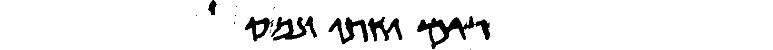

In [176]:
test_image = []
test_image.append(prepareImg(cv2.imread('output_files/image-data/image-data/P583-Fg002-R-C01-R01-fused/slice2_binarize.png'), 50))
showarray(test_image[0])

### Segment the line into different words

50 773


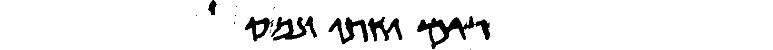

In [160]:
h, w = images[15][2].shape
print(h, w)
showarray(images[15][2])

In [163]:
res = []
# for i, img in enumerate(images[15]):
res = wordSegmentation(images[15][2], kernelSize=5, sigma=5, theta=7, minArea=30) # fix parameters

In [164]:
words = []
# h, w = images[15][2].shape
for (j, w) in enumerate(res):
    (wordBox, wordImg) = w
    (x, y, w, h) = wordBox
    if (w > 20):
        words.append(wordImg)

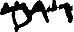

In [165]:
for word in words:
    showarray(word)

In [107]:
print(len(words[0][0]))
single_characters = []
single_characters.append(words[0])

single_characters.append(words[1][:,0:22])
single_characters.append(words[1][:,22:35])
single_characters.append(words[1][:,35:])

single_characters.append(words[2][:,0:17])
single_characters.append(words[2][:,17:40])
single_characters.append(words[2][:,40:60])
single_characters.append(words[2][:,60:])

single_characters.append(words[3][:,0:20])
single_characters.append(words[3][:,15:30])
single_characters.append(words[3][:,30:50])
single_characters.append(words[3][:,50:])

showarray(single_characters[8])
showarray(single_characters[9])
showarray(single_characters[10])
showarray(single_characters[11])
showarray(words[3])

IndexError: list index out of range

In [182]:
word = words[1]
h, w = word.shape
num = 3
chars = []
for i in range(num):
    part = math.floor(w / num)
    char = word[:,part * i:(part * i) + part]
    shape = cv2.resize(char,(32,48))
    ret,thresh1 = cv2.threshold(shape,127,255,cv2.THRESH_BINARY)
    chars.append(thresh1)

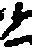

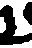

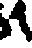

In [183]:
for char in chars:
    showarray(char)

In [184]:
# def get_char(word, x, y):
#     h, w = word.shape
#     chars = []
#     char = word[:,x:y]
#     char = word[:,part * i:(part * i) + part]
#     shape = cv2.resize(char,(32,48))
#     ret,thresh1 = cv2.threshold(shape,127,255,cv2.THRESH_BINARY)
#     chars.append(thresh1)

In [185]:
# chars = []
# chars.append(get_char(word[0], num = 1))
# chars.append(get_char(word[1], num = 1, part = 40))

In [186]:
fonts = []
for item in class_names:
    fonts.append(cv2.imread('habbakuk/' + item + '/standard.png'))

In [105]:
for character in single_characters:
    shape = cv2.resize(character,(32,48))
    ret, thresh1 = cv2.threshold(shape,127,255,cv2.THRESH_BINARY)
    
    char = thresh1
    char_pred = np.asarray(char[:], dtype='float32')
    char_pred = normalize(char_pred)
    char_pred = char_pred.reshape(-1, 48, 32,1)

    prediction = model.predict([char_pred])
    for i in range(len(prediction)):
        print('Predicted: ', prediction[i] * 100)
    highest_index = np.argmax(prediction)
    print('Index of class with highest probability: ',highest_index)
    print('Value of highest probability: ', prediction[0][highest_index])
    print('Name of predicted class: ', class_names[highest_index])
    print('habbabuk/' + class_names[highest_index] + '/standard.png')
    character_example = cv2.imread('habbakuk/' + str(class_names[highest_index]) + '/standard.png')
    showarray(character_example)
    showarray(char_pred)

NameError: name 'single_characters' is not defined

In [188]:
# for box in bounding_boxes:
#     xStart = box[2]
#     xEnd = box[0]
#     y = box[1]
#     winH = box[3] - y
#     winWidth = 5
#     while(xStart-winWidth >= xEnd) :
#         hit = False
#         winW = winWidth
#         a = 0
#         # While the image is not classified and the box has not reached the edge,
#         # increase window size
#         while(not hit and xStart-winW >= xEnd) :
#             newX = xStart - winW
#             # Draw the window
#             clone = img.copy()
#             cv2.rectangle(clone, (xStart, y), (newX, y + winH), (255, 0, 0), 2)
#             cv2.rectangle(clone, (xStart,y),(xEnd,y + winH), (0,255,0), 2)
#             cv2.imshow("Window", clone)
#             cv2.waitKey(0)
#             # Check if the CNN returns a high probability for a letter
#             # for prob in probabilities :
#             #     if prob >= 0.75 :
#             #         hit = True
#             #         xStart = newX
#             # # Increase size of window if nothing has been found
#             winW += 5
#             # this is done to ensure that the loop ends for now, because not
#             # connected to cnn yet.
#             hit = True
#             xStart = newX

In [189]:
# def get_resized_img(img, video_size):
#     width, height = video_size  # these are the MAX dimensions
#     video_ratio = width / height
#     img_ratio = img.size[0] / img.size[1]
#     if video_ratio >= 1:  # the video is wide
#         if img_ratio <= video_ratio:  # image is not wide enough
#             width_new = int(height * img_ratio)
#             size_new = width_new, height
#         else:  # image is wider than video
#             height_new = int(width / img_ratio)
#             size_new = width, height_new
#     else:  # the video is tall
#         if img_ratio >= video_ratio:  # image is not tall enough
#             height_new = int(width / img_ratio)
#             size_new = width, height_new
#         else:  # image is taller than video
#             width_new = int(height * img_ratio)
#             size_new = width_new, height
#     return np.asarray(img.resize(size_new, resample=Image.LANCZOS))

In [190]:
# char = cv2.cvtColor(char, char, cv2.COLOR_BGR2GRAY)